In [1]:
%matplotlib inline

import os
import sys
import timeit
import urllib
import gzip
import pickle
from functools import reduce

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import Ridge
import pandas as pd

sys.path.append(os.path.abspath('..\\dataset'))

import dataset as ds
from dataset.opensets import MNIST
from dataset import B, V, C, F
from dataset import action
from dataset.models.tf import VGG7, VGG16, VGG19
from dataset.models.tf import VNet
from dataset.models.tf import UNet
from dataset.models.tf import SqueezeNet
from dataset.models.tf import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from dataset.models.tf import MobileNet
from dataset.models.tf import LinkNet
from dataset.models.tf import Inception_v1, Inception_v3, Inception_v4
from dataset.models.tf import FCN8, FCN16, FCN32
from dataset.models.tf import DenseNet121, DenseNet169, DenseNet201, DenseNet264
from dataset import Pipeline

from custom_batches import ImagesBatchTimeRecorder

In [2]:
def count_parameters(ppl, model_name):
    layers = ppl.get_model_by_name(model_name).graph.get_collection('trainable_variables')
    return reduce(lambda x, y : x + np.prod(y.get_shape().as_list()), layers, 0)


def get_pipeline(template_pipeline, dataset, pipeline_variables, model_config={}):
    pipeline = template_pipeline << dataset    
    for variable, value in pipeline_variables.items():
        pipeline.set_variable(variable, value)
    pipeline.set_config(model_config)
    return pipeline


def collect_execution_time_stats(pipeline, batch_size, n_experiments):
    pipeline.next_batch(batch_size=batch_size, n_epochs=None)
    for i in range(n_experiments):
        pipeline.next_batch(batch_size=batch_size, n_epochs=None)
    return pipeline.get_variable('exec_time_history')


def measure_exec_time_different_shapes(template_pipeline, dataset, model,
                                       images_shapes, batch_size=10, n_experiments=30,
                                       pipeline_variables={}, model_config={}, classification=True):
    means = []
    stds = []
    n_parameters = []
    pipeline_variables['model_arch'] = model
    for image_shape in tqdm(images_shapes):
        pipeline_variables['shape'] = image_shape
        if not classification:
            pipeline_variables['target_shape'] = image_shape[:2]
        pipeline = get_pipeline(template_pipeline, dataset, pipeline_variables, model_config)
        try:
            diffs = collect_execution_time_stats(pipeline, batch_size, n_experiments)[1:]
        except e:
            print('low memory :(')
            print(e)
            return np.array(means), np.array(stds), np.array(n_parameters) 
        means.append(np.mean(diffs))
        stds.append(np.std(diffs))
        n_parameters.append(count_parameters(pipeline, 'model'))
    return np.array(means), np.array(stds), np.array(n_parameters)

    
def make_df_from_data(mean, std, n_params, classification, batch_size, arch, images_shapes, columns):
    n = len(mean)
    images_shapes = images_shapes[:n]
    classification = classification * np.ones((n, 1))
    segmentation = 1 - classification
    batch = np.ones((n, 1)) * batch_size
    arch = np.repeat(arch, n).reshape(-1,1)
    return pd.DataFrame(np.hstack((arch, classification, segmentation, n_params.reshape(-1,1),
                                   np.array(images_shapes), batch, mean.reshape(-1,1), std.reshape(-1,1))),
                        columns=columns)


def filter_shapes(df, model_name, shapes):
    shapes_to_compute = []
    for shape in shapes:
        if np.any(df[(df.arch == model_name) & (df['input shape height'] == shape)]):
            shapes_to_compute.append(shape)
    return shapes_to_compute


def update_table(df, file, models, dataset, template_pipiline,
                 images_shapes, batch_size, classification, pipeline_variables={}):
    for i, model in enumerate(models):
        print(':', model.__name__)
        shapes_to_compute = filter_shapes(df, model.__name__, images_shapes)
        exec_time_mean, exec_time_std, n_params = measure_exec_time_different_shapes(template_pipiline,
                                                                                     dataset,
                                                                                     model,
                                                                                     shapes_to_compute,
                                                                                     batch_size,
                                                                                     pipeline_variables=pipeline_variables,
                                                                                     classification=classification)
        if len(exec_time_mean) > 0:
            df = df.append(make_df_from_data(exec_time_mean, exec_time_std, n_params, classification,
                                             batch_size, model.__name__, shapes_to_compute, df.columns))
            df.to_csv(file, index=None)
    return df


def plot_exec_time(image_shapes, time_means, time_stds, model_name, batch_size):
    plt.figure(figsize=(16,9))
    plt.errorbar(image_shapes, time_means, yerr=2*time_stds, c='blue', label=model_name)
    plt.title('one batch (size='+str(batch_size)+') execution time in dependence of image size', fontsize=18)
    plt.xlabel('image size', fontsize=18)
    plt.ylabel('seconds', fontsize=18)
    plt.xticks(image_shapes)
    plt.grid()
    plt.legend(fontsize=18)
    
    
def get_stats(models, shapes):
    nns = NeuralNetStat.loc[NeuralNetStat.arch.isin(models)]
    growth_rate = []
    growth_diffs = []
    growth = []
    for i in range(len(shapes)-1):
        df_i = nns.loc[nns['input shape height'] == shapes[i]]['batch processing time']
        df_ip1 = nns.loc[nns['input shape height'] == shapes[i+1]]['batch processing time']
        growth_rate.append(df_ip1.values / df_i.values)
        growth_diffs.append(df_ip1.values - df_i.values)
        growth.append(df_i.values)
    growth.append(nns.loc[nns['input shape height'] == shapes[-1]]['batch processing time'].values)
    names = nns.loc[nns['input shape height'] == shapes[-1]].arch
    return np.array(growth).T, np.array(growth_diffs).T, np.array(growth_rate).T, shapes, names


def plot_group(ax, group, names, title, xticks, xlabel='image size (n x n)', ylabel='seconds'):
    for element, name in zip(group, names):
        ax.plot(xticks, element, label=name)
    ax.legend(fontsize=18)
    ax.grid()
    ax.set_xticks(xticks)
    ax.set_title(title, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    
def plot_growth(growth, growth_diffs, growth_rate, shapes, names):
    f, a = plt.subplots(3, 1, figsize=(16, 21))
#     growth, growth_diffs, growth_rate = get_stats(segmentation_models_names, shapes)
    plot_group(a[0], growth, names, 'Execution times', shapes)
    plot_group(a[1], growth_diffs, names, 'Execution time first order differencу', shapes[:-1])
    plot_group(a[2], growth_rate, names, 'Execution time rate', np.arange(6),'','')

In [11]:
NeuralNetStat = pd.read_csv('NeuralNetStat.csv')
NeuralNetStat.loc[NeuralNetStat.arch == 'DenseNet264']
# NeuralNetStat.loc[NeuralNetStat.arch == 'Res']

,arch,classification,segmentation,#params,input shape height,input shape width,input shape depth,batch size,batch processing time,batch processing time std
56,DenseNet264,1.0,0.0,47414650,2,2,1,10.0,0.295302,0.007220
57,DenseNet264,1.0,0.0,47414650,4,4,1,10.0,0.303102,0.017841
58,DenseNet264,1.0,0.0,47414650,8,8,1,10.0,0.319554,0.024083
59,DenseNet264,1.0,0.0,47414650,16,16,1,10.0,0.321050,0.021145
60,DenseNet264,1.0,0.0,47414650,32,32,1,10.0,0.313179,0.017350
61,DenseNet264,1.0,0.0,47414650,64,64,1,10.0,0.351372,0.006192
62,DenseNet264,1.0,0.0,47414650,128,128,1,10.0,0.680335,0.108690


In [9]:
NeuralNetStat.loc[NeuralNetStat.arch == 'ResNet152']

,arch,classification,segmentation,#params,input shape height,input shape width,input shape depth,batch size,batch processing time,batch processing time std
7,ResNet152,1.0,0.0,88431498,2,2,1,10.0,0.261429,0.006477
8,ResNet152,1.0,0.0,88431498,4,4,1,10.0,0.263868,0.005223
9,ResNet152,1.0,0.0,88431498,8,8,1,10.0,0.262531,0.009006
10,ResNet152,1.0,0.0,88431498,16,16,1,10.0,0.262766,0.004645
11,ResNet152,1.0,0.0,88431498,32,32,1,10.0,0.287623,0.011295
12,ResNet152,1.0,0.0,88431498,64,64,1,10.0,0.341207,0.014719
13,ResNet152,1.0,0.0,88431498,128,128,1,10.0,0.524130,0.003493


In [4]:
def make_labels(batch, *args):
    return batch.labels

# template pipeline which measures the execution time of a batch
time_pipeline = (Pipeline()
         .init_variable('target_shape', None)
         .init_variable('Y', 'labels') # сan be `labels` or `masks`
         .init_variable('Y_generator', make_labels)
         .init_variable('model_arch', VGG16)
         .init_variable('shape', (128,128,1))
         .init_variable('exec_time_history', init_on_each_run=list)
         .init_model('dynamic', V('model_arch'), 'model',
                     config={'inputs' : {'images': {'name': 'resized_images', 'shape': B('image_shape'),
                                                    'data_format':'channels_last'},
                                         V('Y'): {'classes': 10, 'shape' : V('target_shape'),
                                                  'transform': 'ohe', 'name': 'targets'}},
                             'loss' : 'ce',
                             'input_block/inputs' : 'images',
                             'head/targets_shape' : V('shape')})

         .resize(shape=F(lambda _, v : v[:2], v=V('shape')))
         .record_time(stat_name='exec_time_history', mode='record')
         .train_model('model',
                      feed_dict={'images': B('images'),
                                 V('Y'): F(V('Y_generator'))})
         .record_time(stat_name='exec_time_history', mode='diff'))

# dataset to train on
mnist_dataset = MNIST(batch_class=ImagesBatchTimeRecorder)

models = [VGG7, VGG16, VGG19,
          VNet,
          UNet,
          SqueezeNet,
          ResNet18, ResNet34, ResNet50, ResNet101, ResNet152,
          MobileNet,
          LinkNet,
          Inception_v1, Inception_v3, Inception_v4,
          FCN8, FCN16, FCN32,
          DenseNet121, DenseNet169, DenseNet201, DenseNet264]

segmentation_models = [VNet, FCN8, FCN16, FCN32, LinkNet, UNet]
classification_models = list(set(models) - set(segmentation_models))

segmentation_models_names = [model.__name__ for model in segmentation_models]
classification_models_names = [model.__name__ for model in classification_models]

Downloaded train-labels-idx1-ubyte.gz
Extracting C:\Users\GREGOR~1\AppData\Local\Temp\train-labels-idx1-ubyte.gz
Downloaded t10k-labels-idx1-ubyte.gz
Extracting C:\Users\GREGOR~1\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz
Downloaded t10k-images-idx3-ubyte.gz
Extracting C:\Users\GREGOR~1\AppData\Local\Temp\t10k-images-idx3-ubyte.gz
Downloaded train-images-idx3-ubyte.gz
Extracting C:\Users\GREGOR~1\AppData\Local\Temp\train-images-idx3-ubyte.gz


> suppose you want to measure the execution time of MobileNet on batches shaped as (10, 256, 256, 1)

In [5]:
image_shape = (256,256,1)
batch_size = 10

pipeline_variables = {'model_arch' : MobileNet, 'shape' : image_shape}
pipeline = get_pipeline(time_pipeline, mnist_dataset.train, pipeline_variables)

# as the model is assembled on the run, the first batch processing will be lasted relatively long
diffs = collect_execution_time_stats(pipeline, batch_size, 30)[1:]

mean, std = np.mean(diffs), np.std(diffs)

print('mean execution time:       {0:.3f}'.format(mean))
print('std of the execution time: {0:.3f}'.format(std))

mean execution time:       0.341
std of the execution time: 0.007


> Let's compute last statistics for classification models

In [111]:
NeuralNetStat = update_table(NeuralNetStat, 'NeuralNetStat.csv',
                             models=classification_models,
                             dataset=mnist_dataset.train,
                             template_pipiline=time_pipeline,
                             images_shapes=[(2**i, 2**i, 1) for i in range(8, 9)],
                             batch_size=batch_size,
                             classification=True)

: ResNet50


A Jupyter Widget

low memory :(
: ResNet152


A Jupyter Widget

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



low memory :(

: DenseNet121


A Jupyter Widget

low memory :(
: VGG19


A Jupyter Widget

Exception in thread Thread-9:
Traceback (most recent call last):
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



low memory :(

: MobileNet


A Jupyter Widget


: VGG7


A Jupyter Widget

low memory :(
: ResNet34


A Jupyter Widget

Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




: Inception_v1


A Jupyter Widget


: DenseNet264


A Jupyter Widget

low memory :(
: VGG16


A Jupyter Widget

Exception in thread Thread-13:
Traceback (most recent call last):
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



low memory :(

: Inception_v3


A Jupyter Widget


: Inception_v4


A Jupyter Widget


: DenseNet201


A Jupyter Widget

low memory :(
: ResNet101


A Jupyter Widget

Exception in thread Thread-16:
Traceback (most recent call last):
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



low memory :(

: SqueezeNet


A Jupyter Widget


: ResNet18


A Jupyter Widget


: DenseNet169


A Jupyter Widget

low memory :(


> now let's compute statistics for big images

In [22]:
NeuralNetStat = update_table(NeuralNetStat, 'NeuralNetStat.csv',
                             models=[Inception_v1],
                             dataset=mnist_dataset.train,
                             template_pipiline=time_pipeline,
                             images_shapes=[(150,150,1), (200,200,1), (224,224,1)],
                             batch_size=batch_size,
                             classification=True)

: Inception_v1


A Jupyter Widget

> Let's now compute statistics for segmentation models

In [136]:
def make_masks(batch, *args):
    masks = np.zeros_like(batch.images)
    coords = np.where(batch.images > 0)
    masks[coords] = batch.labels[coords[0]]
    return np.squeeze(masks)

In [116]:
image_shape = (255,255,1)
batch_size = 10

pipeline_variables = {'Y' : 'masks', 'model_arch' : LinkNet, 'shape' : image_shape, 'Y_generator' : make_masks,
                      'target_shape' : image_shape[:2]}

pipeline = get_pipeline(time_pipeline, mnist_dataset.train, pipeline_variables)

# as the model is assembled on the run, the first batch processing will be lasted relatively long
diffs = collect_execution_time_stats(pipeline, batch_size, 30)[1:]

mean, std = np.mean(diffs), np.std(diffs)

print('mean execution time:       {0:.3f}'.format(mean))
print('std of the execution time: {0:.3f}'.format(std))

mean execution time:       1.277
std of the execution time: 0.032


In [137]:
NeuralNetStat = update_table(NeuralNetStat, 'NeuralNetStat.csv',
                             models=segmentation_models,
                             dataset=mnist_dataset.train,
                             template_pipiline=time_pipeline,
                             images_shapes=[(150,150,1), (200,200,1), (224,224,1)],
                             batch_size=batch_size,
                             classification=False,
                             pipeline_variables={'Y' : 'masks', 'Y_generator' : make_masks})

: VNet


A Jupyter Widget

: FCN8


A Jupyter Widget

: FCN16


A Jupyter Widget

: FCN32


A Jupyter Widget

: LinkNet


A Jupyter Widget

: UNet


A Jupyter Widget

# Segmentation models

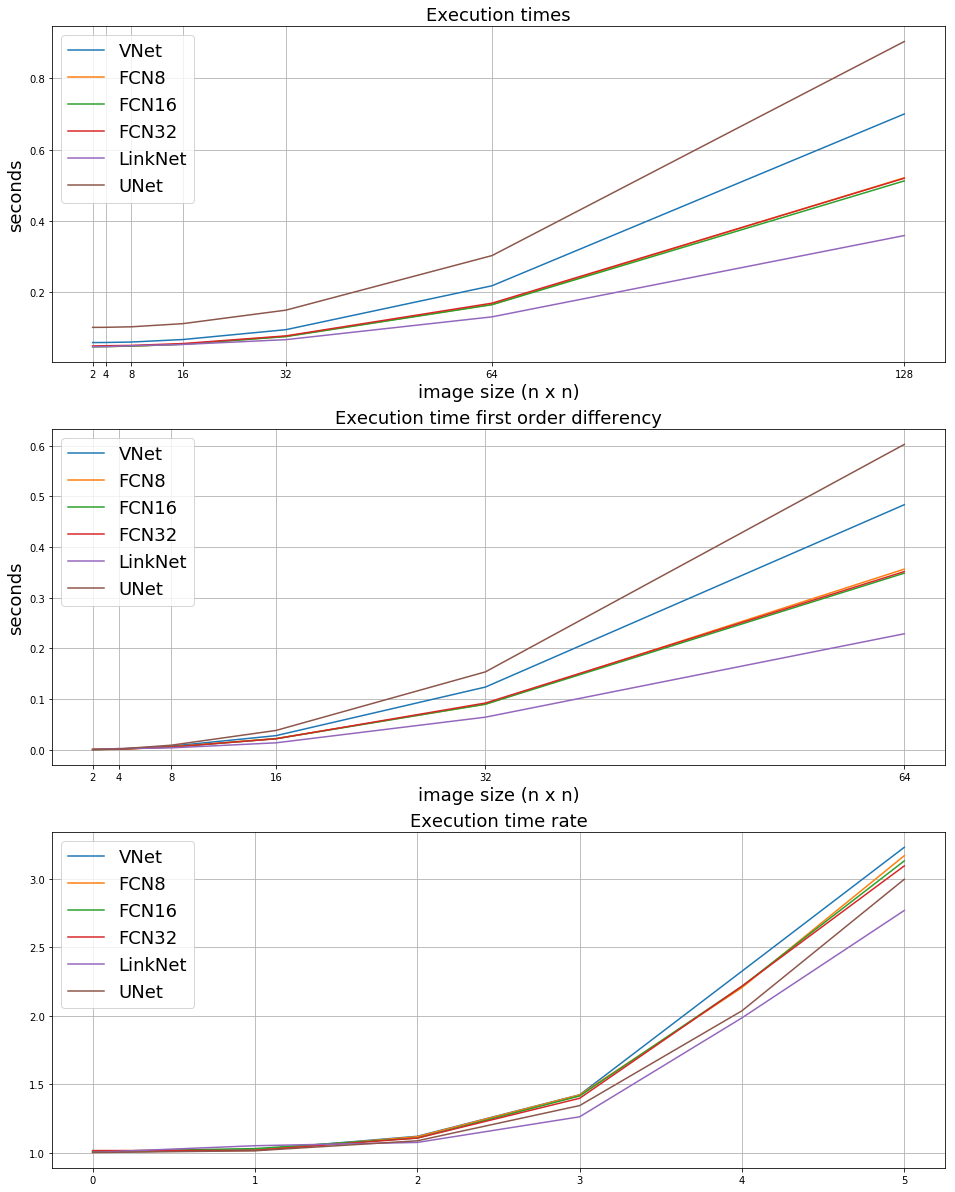

In [291]:
plot_growth(*get_stats(segmentation_models_names,  [(2**i) for i in range(1, 8)]))

# ResNets

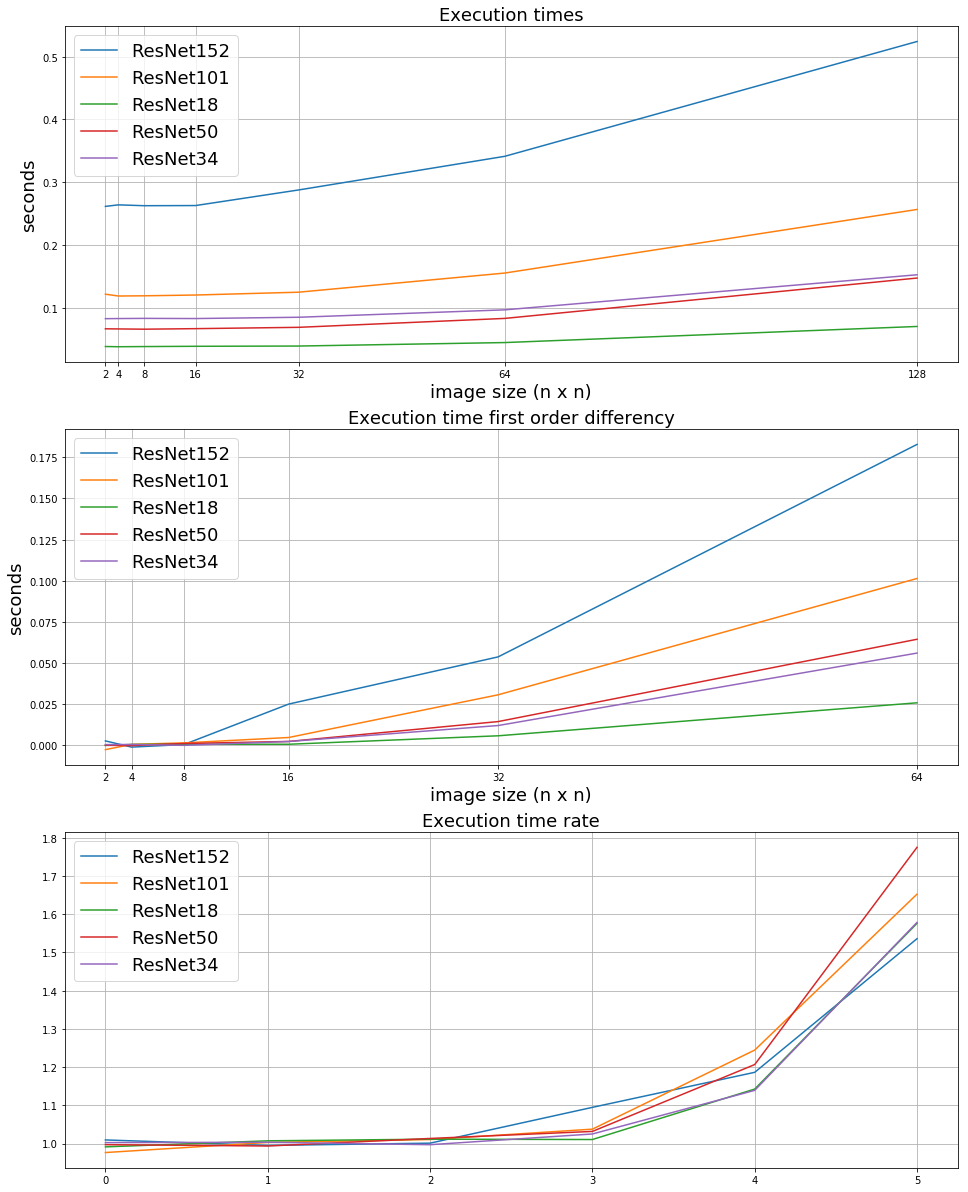

In [290]:
plot_growth(*get_stats([i for i in classification_models_names if i.startswith('Res')], [(2**i) for i in range(1, 8)]))

# DenseNets

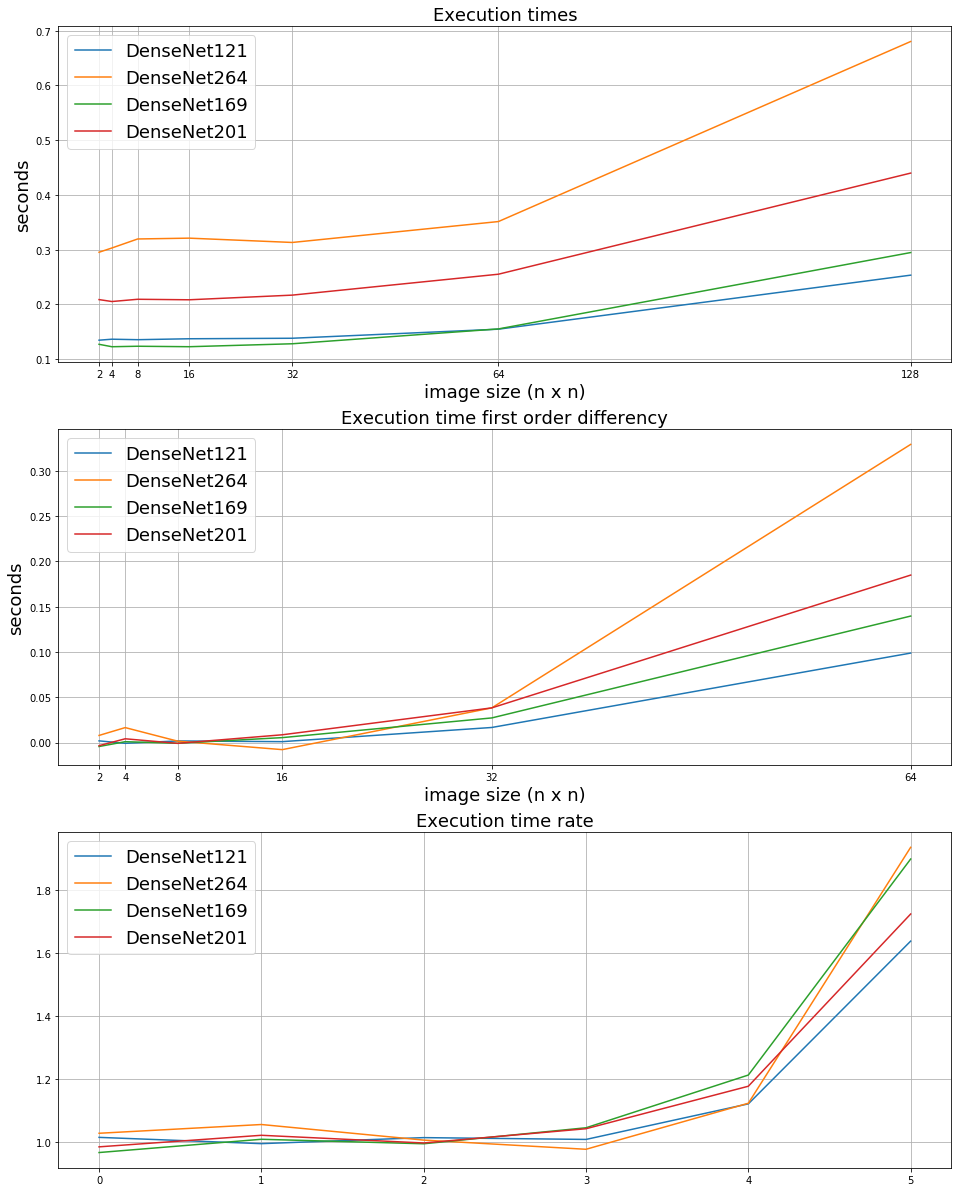

In [294]:
plot_growth(*get_stats([i for i in classification_models_names if i.startswith('Dense')],  [(2**i) for i in range(1, 8)]))

# VGGs

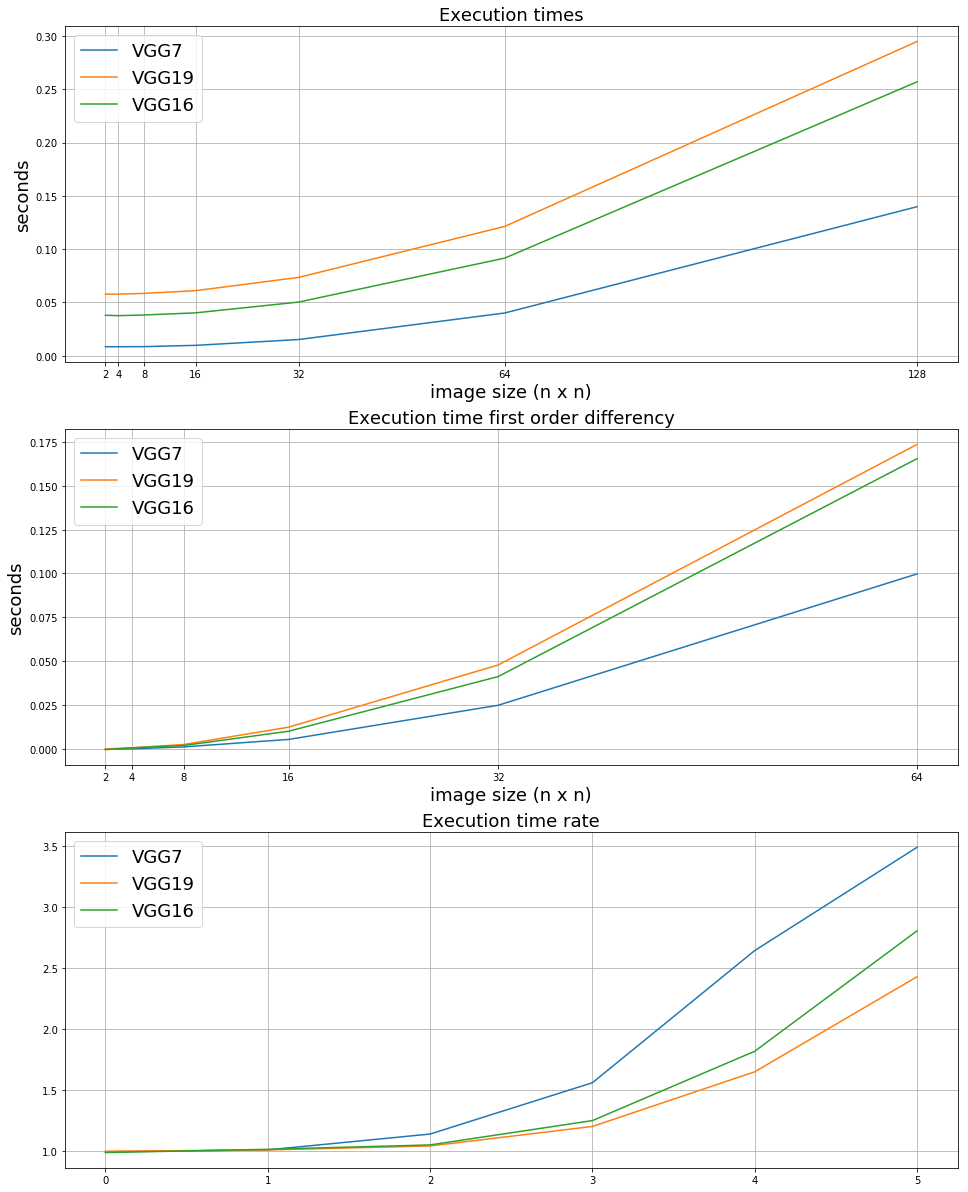

In [295]:
plot_growth(*get_stats([i for i in classification_models_names if i.startswith('VGG')],  [(2**i) for i in range(1, 8)]))

# "light networks"

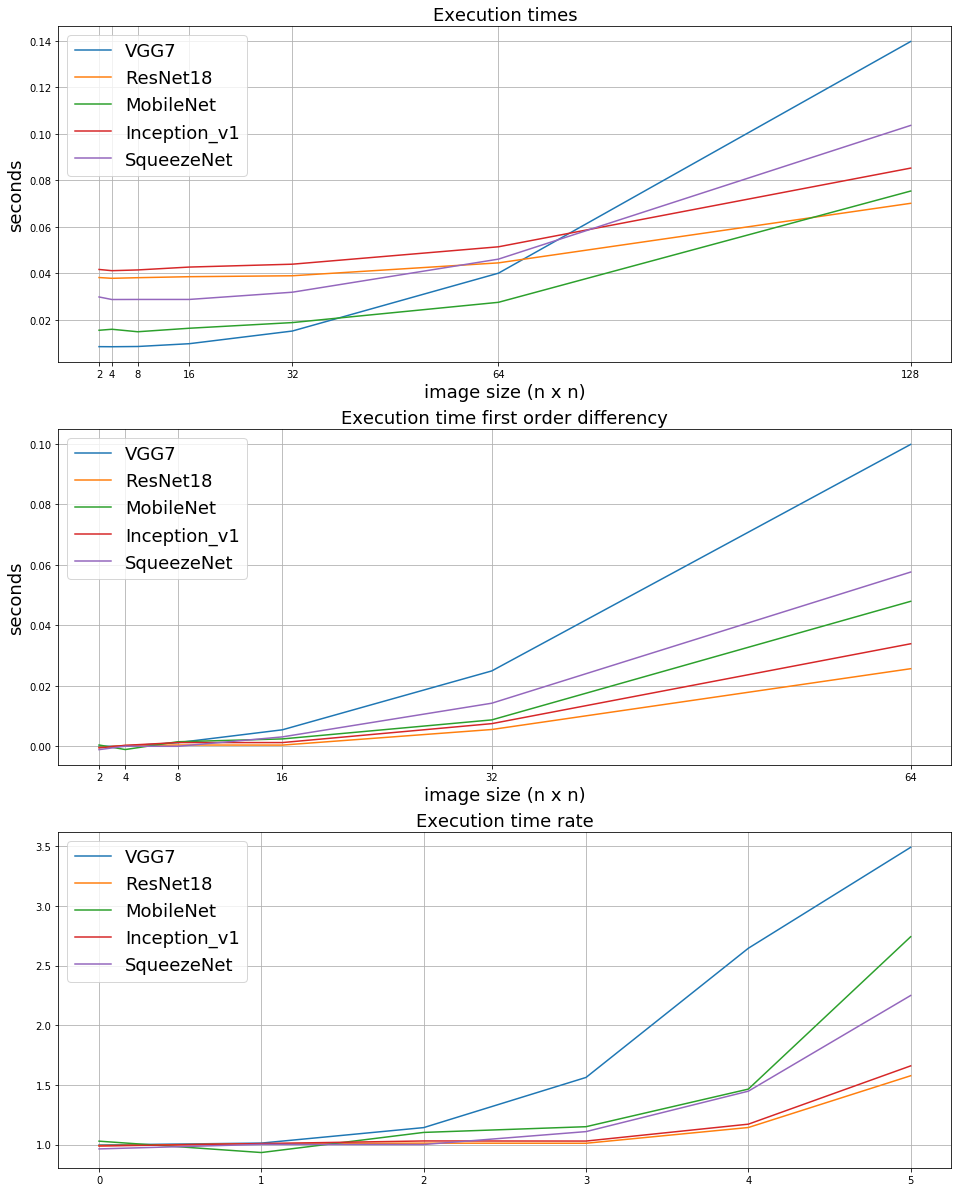

In [311]:
plot_growth(*get_stats(['MobileNet', 'ResNet18', 'VGG7', 'Inception_v1', 'SqueezeNet'], [(2**i) for i in range(1, 8)]))

# "Heavy Networks" 

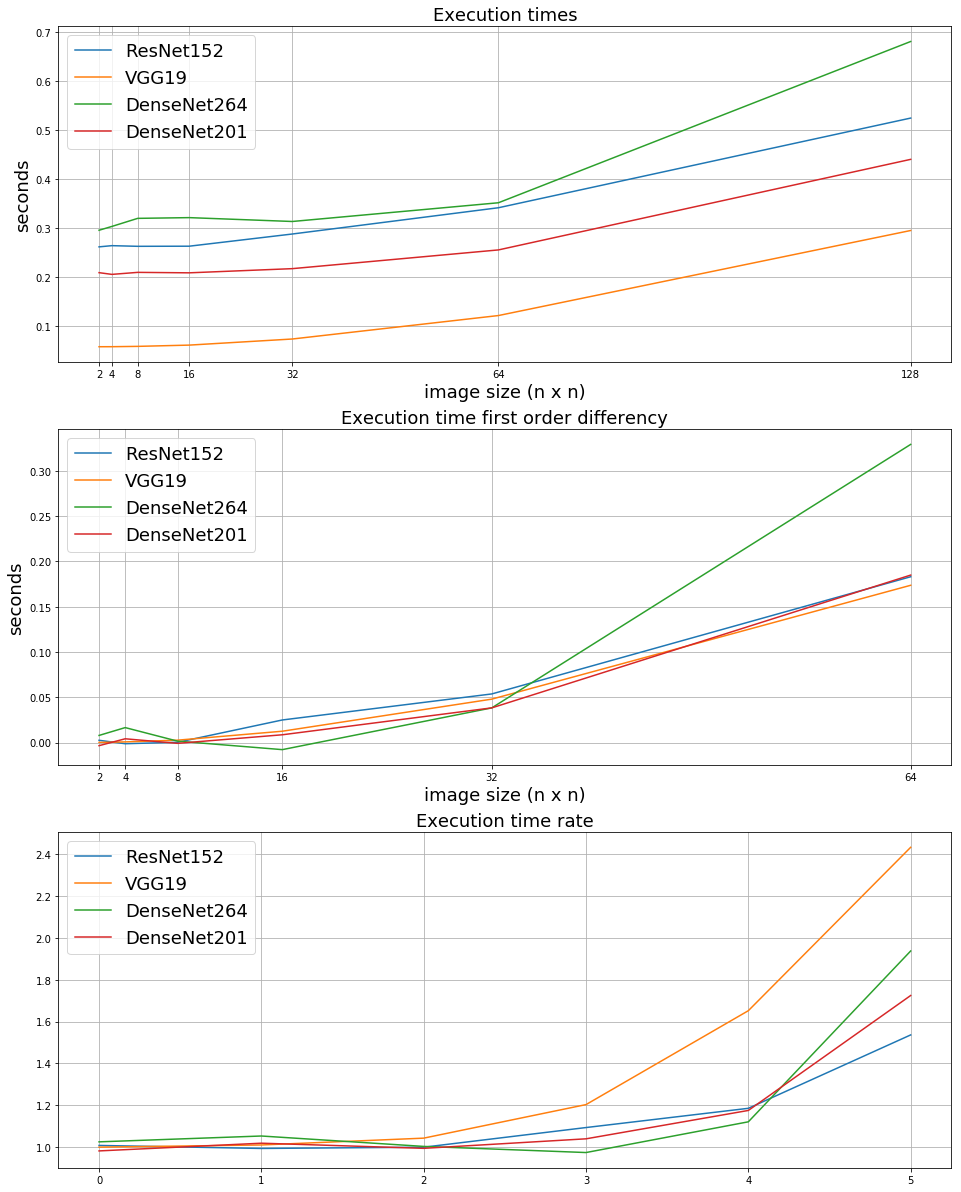

In [307]:
plot_growth(*get_stats(['VGG19', 'ResNet152', 'DenseNet264', 'DenseNet201'], [(2**i) for i in range(1, 8)]))

# Light vs Heavy

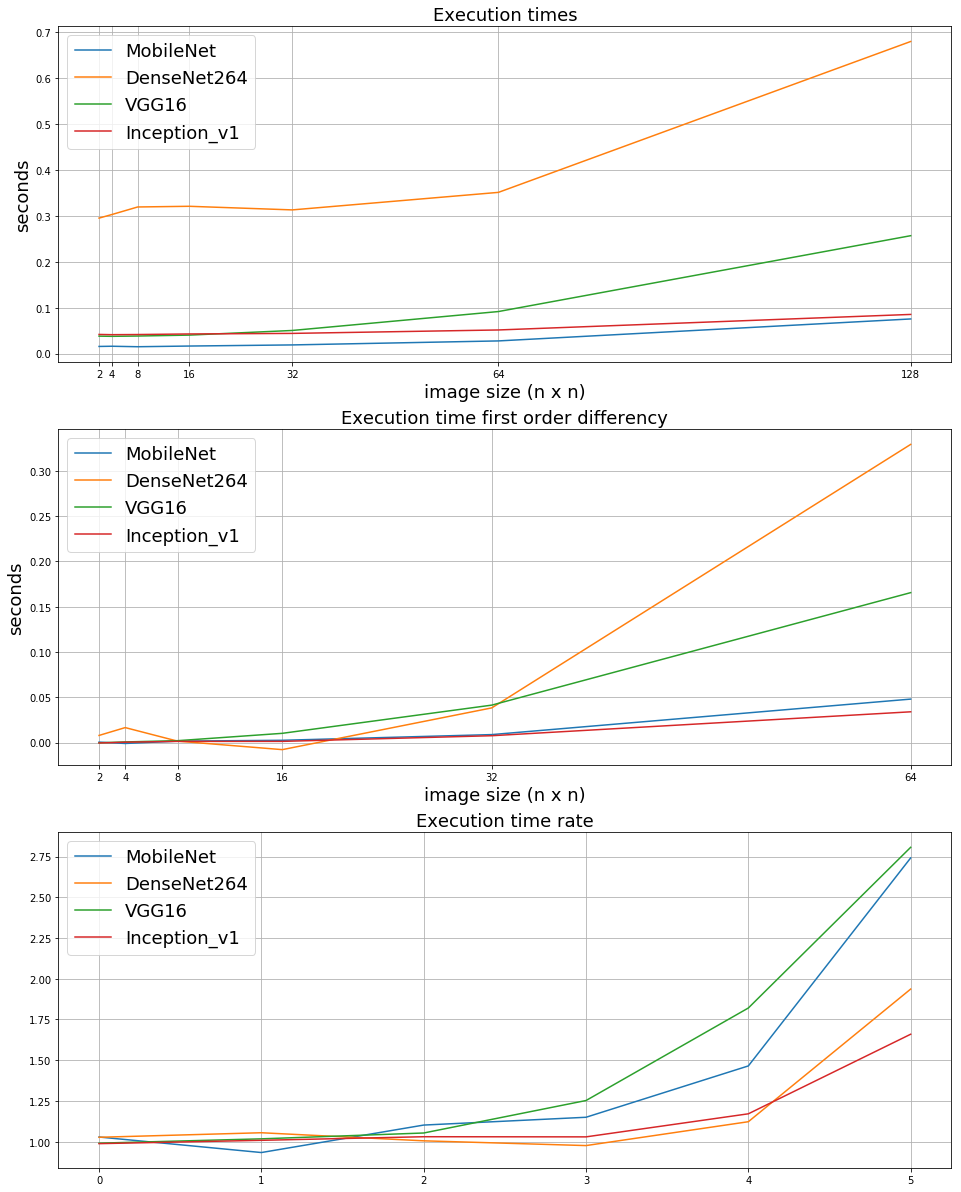

In [5]:
plot_growth(*get_stats(['Inception_v1', 'DenseNet264', 'VGG16', 'MobileNet'], [(2**i) for i in range(1, 8)]))

In [6]:
NeuralNetStat.loc

,arch,classification,segmentation,#params,input shape height,input shape width,input shape depth,batch size,batch processing time,batch processing time std
0,DenseNet121,1.0,0.0,16423290,2,2,1,10.0,0.134624,0.013625
1,DenseNet121,1.0,0.0,16423290,4,4,1,10.0,0.136429,0.006098
2,DenseNet121,1.0,0.0,16423290,8,8,1,10.0,0.135527,0.003935
3,DenseNet121,1.0,0.0,16423290,16,16,1,10.0,0.137231,0.005240
4,DenseNet121,1.0,0.0,16423290,32,32,1,10.0,0.138167,0.003359
5,DenseNet121,1.0,0.0,16423290,64,64,1,10.0,0.154745,0.002335
6,DenseNet121,1.0,0.0,16423290,128,128,1,10.0,0.253441,0.002282
7,ResNet152,1.0,0.0,88431498,2,2,1,10.0,0.261429,0.006477
8,ResNet152,1.0,0.0,88431498,4,4,1,10.0,0.263868,0.005223
9,ResNet152,1.0,0.0,88431498,8,8,1,10.0,0.262531,0.009006
